In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, confusion_matrix

import tqdm

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

In [2]:
train=pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv',low_memory=False)

In [3]:
train.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
train.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [5]:
test=pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv',low_memory=False)

In [6]:
test.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [7]:
test.describe()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,48.333333,2.793333,21.235613,16.534205,30.055107,27.650733,36.939135,32.498746,54.900061,59.695153,...,0.621704,7.952809,0.178523,1.211260,2.339005,0.423880,51.666667,-117.242387,1148.245296,23.461588
std,15.275252,0.330051,4.037983,5.955101,1.508777,0.679182,1.795292,2.930254,6.153928,9.525959,...,0.578214,1.531253,0.158981,0.113509,0.348961,0.056670,50.579970,35.636913,461.012045,78.683844
min,35.000000,2.520000,16.648670,9.657964,28.384120,27.043640,35.467806,29.169579,51.220960,53.505430,...,0.000000,6.340311,0.000000,1.080308,2.011223,0.366071,20.000000,-155.065100,629.535889,-28.576050
25%,40.000000,2.610000,19.726500,14.797672,29.423900,27.283979,35.938953,31.404790,51.347845,54.210420,...,0.360870,7.235590,0.115371,1.176124,2.155579,0.396150,22.500000,-133.717170,966.756944,-21.797669
50%,45.000000,2.700000,22.804330,19.937380,30.463680,27.524318,36.410100,33.640000,51.474730,54.915410,...,0.721739,8.130868,0.230742,1.271940,2.299935,0.426230,25.000000,-112.369240,1303.978000,-15.019287
75%,55.000000,2.930000,23.529085,19.972325,30.890600,27.954279,37.674800,34.163330,56.739612,62.790014,...,0.932557,8.759058,0.267784,1.276736,2.502896,0.452784,67.500000,-98.331030,1407.600000,49.480406
max,65.000000,3.160000,24.253840,20.007270,31.317520,28.384240,38.939500,34.686660,62.004494,70.664619,...,1.143374,9.387248,0.304827,1.281532,2.705857,0.479339,110.000000,-84.292820,1511.222000,113.980100


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [9]:
targets=train['target']

In [10]:
cols_unique_train=[col for col in train.columns if col not in test.columns]

In [11]:
cols_unique_train

['target',
 'lesion_id',
 'iddx_full',
 'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence']

In [12]:
train.shape,test.shape

((401059, 55), (3, 44))

In [13]:
train_df=train.drop(cols_unique_train,axis=1)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   isic_id                      401059 non-null  object 
 1   patient_id                   401059 non-null  object 
 2   age_approx                   398261 non-null  float64
 3   sex                          389542 non-null  object 
 4   anatom_site_general          395303 non-null  object 
 5   clin_size_long_diam_mm       401059 non-null  float64
 6   image_type                   401059 non-null  object 
 7   tbp_tile_type                401059 non-null  object 
 8   tbp_lv_A                     401059 non-null  float64
 9   tbp_lv_Aext                  401059 non-null  float64
 10  tbp_lv_B                     401059 non-null  float64
 11  tbp_lv_Bext                  401059 non-null  float64
 12  tbp_lv_C                     401059 non-null  float64
 13 

In [15]:
for col in train_df.columns:
    if((train_df[col].dtype=='float64' or train_df[col].dtype=='int64') and train_df[col].isna().sum()!=0):
        train_df[col].fillna(value=train_df[col].mean(),inplace=True);
    if(train_df[col].dtype=='object' and train_df[col].isna().sum()!=0):
        train_df[col].fillna(value=train_df[col].mode()[0],inplace=True);

/tmp/ipykernel_33/2966992500.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(value=train_df[col].mean(),inplace=True);
/tmp/ipykernel_33/2966992500.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [16]:
for col in train_df.columns:
    print(col,':',train_df[col].isna().sum())

isic_id : 0
patient_id : 0
age_approx : 0
sex : 0
anatom_site_general : 0
clin_size_long_diam_mm : 0
image_type : 0
tbp_tile_type : 0
tbp_lv_A : 0
tbp_lv_Aext : 0
tbp_lv_B : 0
tbp_lv_Bext : 0
tbp_lv_C : 0
tbp_lv_Cext : 0
tbp_lv_H : 0
tbp_lv_Hext : 0
tbp_lv_L : 0
tbp_lv_Lext : 0
tbp_lv_areaMM2 : 0
tbp_lv_area_perim_ratio : 0
tbp_lv_color_std_mean : 0
tbp_lv_deltaA : 0
tbp_lv_deltaB : 0
tbp_lv_deltaL : 0
tbp_lv_deltaLB : 0
tbp_lv_deltaLBnorm : 0
tbp_lv_eccentricity : 0
tbp_lv_location : 0
tbp_lv_location_simple : 0
tbp_lv_minorAxisMM : 0
tbp_lv_nevi_confidence : 0
tbp_lv_norm_border : 0
tbp_lv_norm_color : 0
tbp_lv_perimeterMM : 0
tbp_lv_radial_color_std_max : 0
tbp_lv_stdL : 0
tbp_lv_stdLExt : 0
tbp_lv_symm_2axis : 0
tbp_lv_symm_2axis_angle : 0
tbp_lv_x : 0
tbp_lv_y : 0
tbp_lv_z : 0
attribution : 0
copyright_license : 0


In [17]:
targets.value_counts()

target
0    400666
1       393
Name: count, dtype: int64

<Axes: >

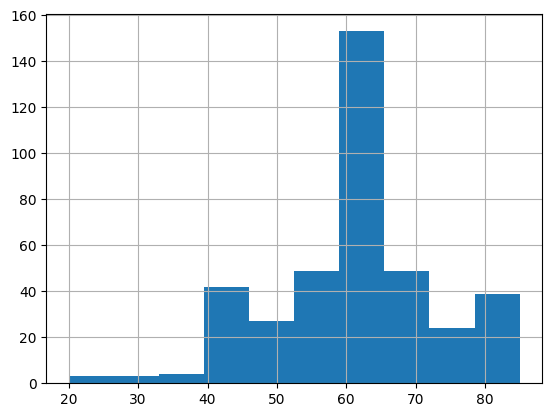

In [18]:
train_df[targets==1]['age_approx'].hist()

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   isic_id                      401059 non-null  object 
 1   patient_id                   401059 non-null  object 
 2   age_approx                   401059 non-null  float64
 3   sex                          401059 non-null  object 
 4   anatom_site_general          401059 non-null  object 
 5   clin_size_long_diam_mm       401059 non-null  float64
 6   image_type                   401059 non-null  object 
 7   tbp_tile_type                401059 non-null  object 
 8   tbp_lv_A                     401059 non-null  float64
 9   tbp_lv_Aext                  401059 non-null  float64
 10  tbp_lv_B                     401059 non-null  float64
 11  tbp_lv_Bext                  401059 non-null  float64
 12  tbp_lv_C                     401059 non-null  float64
 13 

In [20]:
obj_but_not_cat=['isic_id','image_type','copyright_license','patient_id','attribution']

In [21]:
for col in train_df.columns:
    if train_df[col].dtype=='object':
        print(col)

isic_id
patient_id
sex
anatom_site_general
image_type
tbp_tile_type
tbp_lv_location
tbp_lv_location_simple
attribution
copyright_license


In [22]:
cat_labels=[col for col in train_df.columns if (train_df[col].dtype=='object' and col not in obj_but_not_cat)]

In [23]:
cat_labels

['sex',
 'anatom_site_general',
 'tbp_tile_type',
 'tbp_lv_location',
 'tbp_lv_location_simple']

In [24]:
encoder=LabelEncoder()
for col in cat_labels:
    train_df[col]=encoder.fit_transform(train_df[col])

In [25]:
cat_labels

['sex',
 'anatom_site_general',
 'tbp_tile_type',
 'tbp_lv_location',
 'tbp_lv_location_simple']

In [26]:
train_df['image_type'].value_counts()

image_type
TBP tile: close-up    401059
Name: count, dtype: int64

In [27]:
df1=train_df.drop(obj_but_not_cat,axis=1)

<Axes: >

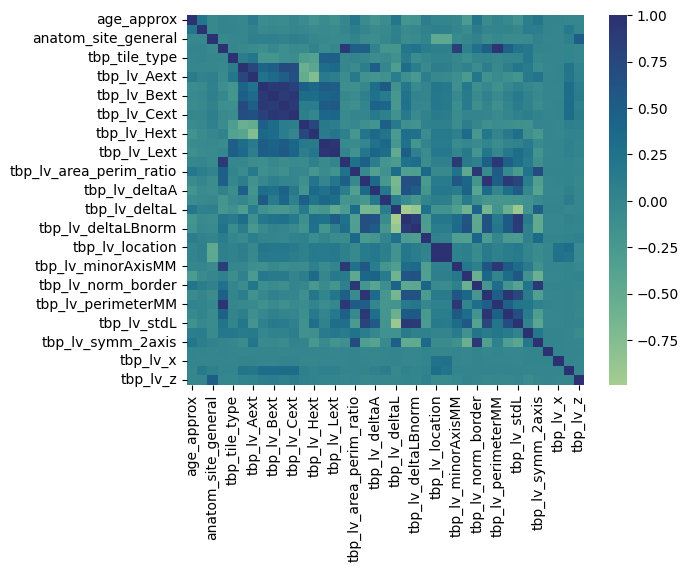

In [28]:
sns.heatmap(df1.corr(),cmap="crest")

In [29]:
correlation_pairs=df1.corr().unstack()
correlation_pairs

age_approx  age_approx                 1.000000
            sex                        0.214247
            anatom_site_general       -0.035237
            clin_size_long_diam_mm     0.016120
            tbp_tile_type             -0.002887
                                         ...   
tbp_lv_z    tbp_lv_symm_2axis         -0.004006
            tbp_lv_symm_2axis_angle   -0.001102
            tbp_lv_x                  -0.008242
            tbp_lv_y                  -0.012079
            tbp_lv_z                   1.000000
Length: 1521, dtype: float64

In [30]:
len(df1.columns)

39

In [31]:
correlation_df = pd.DataFrame(correlation_pairs, columns=['correlation'])

In [32]:
sorted_correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

In [33]:
sorted_correlation_df.iloc[39:59:2]

correlation
tbp_lv_location             tbp_lv_location_simple      0.993623
tbp_lv_perimeterMM          clin_size_long_diam_mm      0.965004
tbp_lv_norm_color           tbp_lv_color_std_mean       0.964572
tbp_lv_Lext                 tbp_lv_L                    0.960190
tbp_lv_radial_color_std_max tbp_lv_norm_color           0.958957
tbp_lv_Bext                 tbp_lv_Cext                 0.939995
tbp_lv_norm_border          tbp_lv_symm_2axis           0.924140
                            tbp_lv_area_perim_ratio     0.921085
tbp_lv_minorAxisMM          tbp_lv_perimeterMM          0.920608
tbp_lv_B                    tbp_lv_C                    0.920575

In [34]:
benign,malignant=train_df[targets==0],train_df[targets==1]

In [35]:
def two_col_bar_plot(df,col1,col2,targets=None):
    sns.barplot(data=df,x=col1,y=col2,hue=targets)

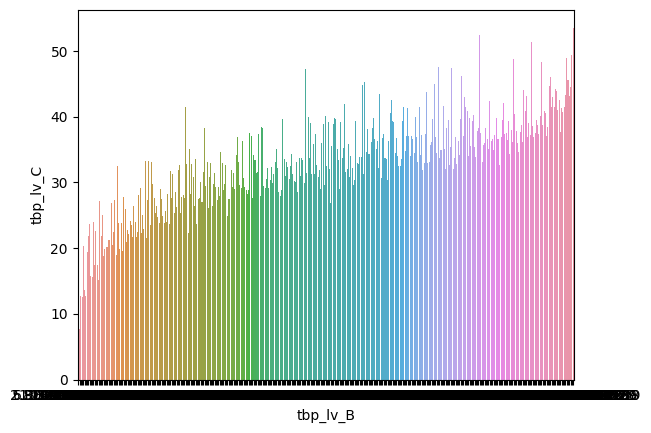

In [36]:
two_col_bar_plot(malignant,'tbp_lv_B','tbp_lv_C')

<Axes: xlabel='tbp_lv_norm_color', ylabel='tbp_lv_color_std_mean'>

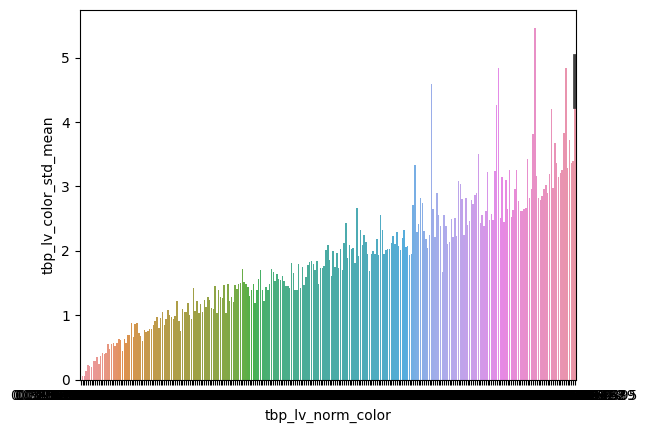

In [37]:
plt.figure()
sns.barplot(data=malignant,x='tbp_lv_norm_color',y='tbp_lv_color_std_mean')

In [38]:
X=df1
y=targets

In [39]:
X.shape,y.shape

((401059, 39), (401059,))

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
rf.fit(X, y)

print(f"RF train accuracy: {rf.score(X, y):.3f}")

RF train accuracy: 1.000


In [41]:
feat_importances = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = True)
feat_importances

sex                            0.003822
anatom_site_general            0.006659
tbp_tile_type                  0.007122
tbp_lv_location_simple         0.007667
tbp_lv_location                0.011722
age_approx                     0.016833
tbp_lv_symm_2axis_angle        0.020624
tbp_lv_norm_color              0.021636
tbp_lv_color_std_mean          0.022620
tbp_lv_Cext                    0.023194
tbp_lv_nevi_confidence         0.024210
tbp_lv_C                       0.025058
tbp_lv_deltaL                  0.025107
tbp_lv_radial_color_std_max    0.025904
tbp_lv_deltaLB                 0.025945
tbp_lv_Bext                    0.026291
tbp_lv_stdL                    0.026442
tbp_lv_symm_2axis              0.026915
tbp_lv_Lext                    0.027258
tbp_lv_eccentricity            0.027271
tbp_lv_norm_border             0.027668
tbp_lv_area_perim_ratio        0.027829
tbp_lv_Aext                    0.028336
tbp_lv_z                       0.028828
tbp_lv_deltaA                  0.029299


In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age_approx                   401059 non-null  float64
 1   sex                          401059 non-null  int64  
 2   anatom_site_general          401059 non-null  int64  
 3   clin_size_long_diam_mm       401059 non-null  float64
 4   tbp_tile_type                401059 non-null  int64  
 5   tbp_lv_A                     401059 non-null  float64
 6   tbp_lv_Aext                  401059 non-null  float64
 7   tbp_lv_B                     401059 non-null  float64
 8   tbp_lv_Bext                  401059 non-null  float64
 9   tbp_lv_C                     401059 non-null  float64
 10  tbp_lv_Cext                  401059 non-null  float64
 11  tbp_lv_H                     401059 non-null  float64
 12  tbp_lv_Hext                  401059 non-null  float64
 13 

In [63]:
sum=0
for col in train.columns:
    if(train[col].dtype=='object' and col not in ['isic_id','patient_id','lesion_id']):
        print(len(set(train[col])),col)
        sum+=len(set(train[col]))

3 sex
6 anatom_site_general
1 image_type
2 tbp_tile_type
21 tbp_lv_location
8 tbp_lv_location_simple
7 attribution
3 copyright_license
52 iddx_full
3 iddx_1
15 iddx_2
26 iddx_3
27 iddx_4
2 iddx_5
8 mel_mitotic_index


In [64]:
sum

184